# HybridRAG for QM FAQ
- Prerequisite: Need to have the KG ready before running this notebook. The KG is created by running this notebook "V3-Semiautomatic KG Ontology for QM FAQ.ipynb" in this repository. This mentioned notebook semi-auttomatically creates the KG using a pre-built JSON file. Also the JSON can be iteratively improvised by visualizing the KG in Neo4j as explained in that notebook.
- The HybridRAG pipeline uses Neo4j Graph DB that contains both triplets (subject, relattion, object) and DocumentChunk nodes (raw chunks with chunk embeddings).
- This HybridRAG pipeline formats the context of the prompt by finding the top-k chunks by Vector Search on Neo4j Chunk Embedding Index, then finds the triplets that has some node(s) mentioned in the Chunk and the 1-hop neighbours of these nodes.
- So the context has 2 parts: Unstructured Raw chunks and Structured Triplets.
- The full prompt is formed by combining the User Query, Context, Instructions.
- The full prompt is fed into an LLM e.g., gpt-3.5-turbo to generate the RAG response.

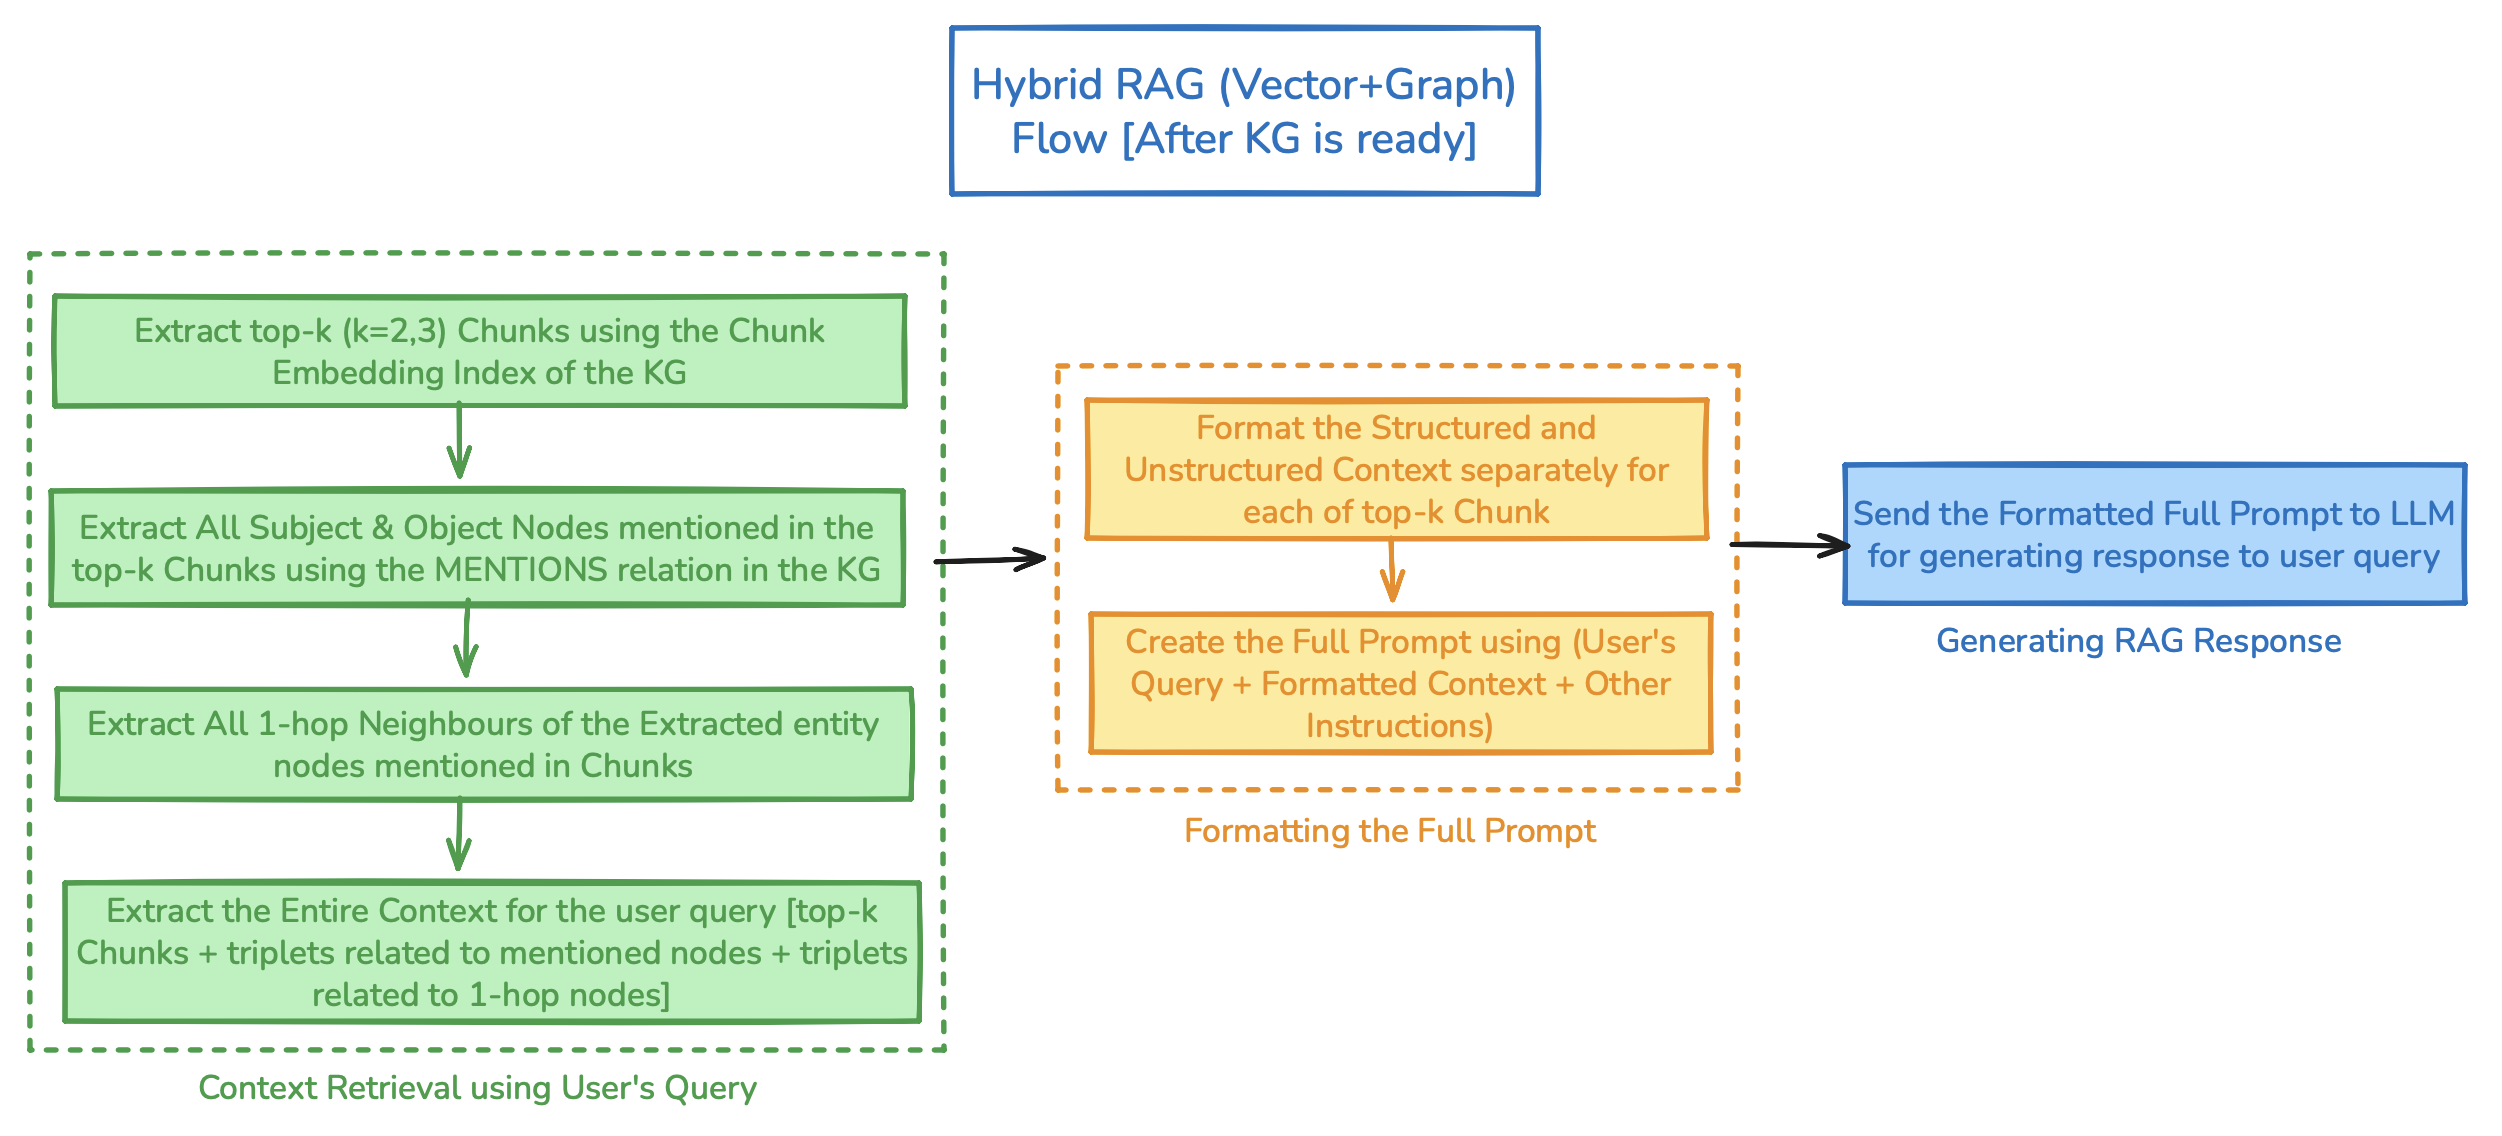

### Installation

In [ ]:
# !pip install neo4j neo4j-graphrag openai
!pip install neo4j neo4j-graphrag langchain-community pypdf openai tiktoken

### Imports

In [ ]:
# import os
# import json
# from neo4j import GraphDatabase
# from neo4j-graphrag.embeddings.openai import OpenAIEmbeddings
# from neo4j-graphrag.retrievers import HybridRetriever

import os
from typing import List

# Imports for PDF Processing
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Imports for Neo4j and Embeddings
from neo4j import GraphDatabase
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings
from neo4j_graphrag.retrievers import HybridRetriever
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

# Import SentenceTransformer for Embedding model
from sentence_transformers import SentenceTransformer

### CONFIG

In [ ]:
DATA_PATH = ""

CONFIG_DICT = {
    "EMB_MODEL": "sentence-transformers/all-MiniLM-L6-v2", # "text-embedding-ada-002"
    "RAG_MODEL": "gpt-3.5-turbo",
    "VECTOR_INDEX_NAME": "QM_Embedding",
    "FULLTEXT_INDEX_NAME": "QM_Fulltext"
}

In [ ]:
EMB_MODEL = CONFIG_DICT["EMB_MODEL"]
RAG_MODEL = CONFIG_DICT["RAG_MODEL"]
VECTOR_INDEX_NAME = CONFIG_DICT["VECTOR_INDEX_NAME"]
FULLTEXT_INDEX_NAME = CONFIG_DICT["FULLTEXT_INDEX_NAME"]

### (Neo4j+OpenAI) API Keys

In [ ]:
from google.colab import userdata, drive
NEO4J_URI = userdata.get('NEO4J_URI')
NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY_1')
DATA_PATH = userdata.get("QM_DATA_PATH")

### Access Docs from Drive

In [ ]:
# --- Mount Google Drive ---
# This allows the script to access your PDF file from Google Drive.
import time
drive.mount('/content/drive')
print("Google Drive mounted successfully.")
time.sleep(10)

In [ ]:
import glob
qm_pdf_path_arr = glob.glob(os.path.join(DATA_PATH, "*.pdf"))
print(qm_pdf_path_arr)
pdf_path = qm_pdf_path_arr[0]

### Neo4j Util Functions

In [ ]:
def get_neo4j_credentials():
    return NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD

## Funttion to get Neo4j DB driver
def get_driver():
    """Creates a Neo4j driver instance."""
    uri, user, password = get_neo4j_credentials()
    return GraphDatabase.driver(uri, auth=(user, password), max_connection_lifetime=3600)

### Util Function to extract context (both unstructured & structured) using the user's query:
1. **Unstructured Context**: Do a vector search of chunks embeddings that are similar to query embedding. Take top-k (k=2,3).
2. **Structured Context**: From the above top-k unstructured chunks, find out all the mentioned nodes/entities and the nodes at 1-hop distance from them.

In [ ]:
## Extract (Unstructured + Structured) Context from KG using the user query embedding

def get_hybrid_context(driver, query_text, embedder, top_k=3):
    """
    Retrieves both unstructured text (Vector) and structured facts (Graph)
    in a single Cypher query.
    """

    # 1. Generate Embedding for the User Query
    print(f"Generating embedding for query: '{query_text}'...")
    query_vector = embedder.encode(query_text, convert_to_tensor=False)

    # 2. The "Single Shot" Cypher Query
    # Logic: Find Chunks -> Find Mentioned Entities -> Find 1-Hop Neighbors
    cypher_query = """
    // Step 1: Vector Search to find relevant DocumentChunks
    CALL db.index.vector.queryNodes($index_name, $k, $query_vector)
    YIELD node AS chunk, score

    // Step 2: Traverse to Mentioned Entities and their 1-Hop Neighbors
    // We use OPTIONAL MATCH so we don't lose the chunk if it mentions nothing
    OPTIONAL MATCH (chunk)-[:MENTIONS]->(entity)-[r]-(neighbor)

    // Step 3: Filter out irrelevant nodes (e.g., don't traverse back to other Chunks)
    WHERE NOT 'DocumentChunk' IN labels(neighbor)

    // Step 4: Format the Graph Facts into readable strings
    // We use startNode/endNode to preserve the direction of the relationship
    WITH chunk, score,
         startNode(r).name + ' ' + type(r) + ' ' + endNode(r).name AS triple_str

    // Step 5: Aggregate results per Chunk
    RETURN
        chunk.text AS chunk_text,
        score,
        // Collect distinct triplets to remove duplicates within the same hop
        collect(DISTINCT triple_str) AS graph_context
    """

    print("Executing Graph+Vector retrieval...")
    with driver.session() as session:
        result = session.run(
            cypher_query,
            index_name=VECTOR_INDEX_NAME,
            k=top_k,
            query_vector=query_vector
        )

        # 3. Format the Output for the LLM
        retrieved_data = []
        for record in result:
            retrieved_data.append({
                "score": record["score"],
                "text": record["chunk_text"],
                "graph_facts": record["graph_context"]
            })

    return retrieved_data

### Util Funcion to Get the formattted prompt using both (Unstructurerd + Structured) Context extracted using the function get_hybrid_context()

In [ ]:
def format_context_for_prompt(retrieved_data):
    """
    Formats the retrieved context into the required structure for the LLM.
    """
    context_blocks = []
    i = 0
    for item in retrieved_data:
        # Create the structured triplets section
        facts_list = "\n".join([f"- {fact}" for fact in item['graph_facts']])

        # Create the combined block
        block = f"""
------------------------------
Context Block {i} (Relevance Score: {item['score']:.4f}):
[RAW TEXT]:
{item['text']}

[KNOWLEDGE GRAPH FACTS]:
{facts_list if facts_list else 'No specific graph facts were linked to this chunk.'}
------------------------------
"""
        context_blocks.append(block)
        i += 1
    return "\n".join(context_blocks)

### Util Function to Get RAG response given (User's Query + Retrieved Context)

In [ ]:
def get_query_response_from_llm(llm_model, query_text, formatted_context):
    pass

    # 1. Create the Full Prompt
    full_prompt = f"""
    System Instruction:
    You are an expert in Quantum Physics and Knowledge Graphs. Your task is to synthesize the information provided in the Context Blocks below to accurately and comprehensively answer the user's question. For the final answer, prioritize using the explicit facts found in the [KNOWLEDGE GRAPH FACTS] section to support and enrich the explanations found in the [RAW TEXT] section.

    [USER QUERY]: {query_text}

    Context Blocks:
    {formatted_context}

    ---
    Based on the provided Context Blocks, provide a detailed and authoritative answer to the user query.
    """

    # 2. Initialize and call the LLM
    llm = OpenAILLM(
        model_name=RAG_MODEL,
        model_params={"temperature": 0.2},
        api_key=OPENAI_API_KEY
    )

    # We use a custom call here instead of the full GraphRAG class to use our custom prompt structure
    print(f"\n--- Sending request to LLM ({RAG_MODEL}) ---")

    # The neo4j-graphrag LLM wrapper handles the API call
    # response = llm.generate([full_prompt])
    # return response.generations[0].text

    response = llm.invoke(full_prompt)
    return response.content

### Sample User Queries on "Spin & Entanglement"

In [ ]:
# query_text = "What is Spin in Quantum Mechanics?"
# query_text = "Can you give some examples where several spins are connected together and create too many possible superposition states?"

questions_arr = ["What is Spin in Quantum Mechanics?",
                 "Is there any way the Spin (in Quantum Mechanics) can be used for MRI on the human body? If yes, then How?", # [Multi-query]
                 "How important is the Spin in Quantum Mechanics?",
                 "Can you give some examples where several spins are connected together and create too many possible superposition states?",
                 "What is it that Quantum Computer can easily achieve, but Classical Computer fails to do?",
                 "Can you give some example use cases where Quantum Computers play a crucial role?",
                 "What is Quantum Cryptography?",
                 "Why is Quantum Cryptography needed?",
                 "What is Quantum Entanglement?",
                 "Why is Quantum Entanglement difficult to understand? Meaning, what are the pain points in understanding this topic?",
                 "How is Quantum Entanglement connected to Schrodinger’s cat?",
                 "What is teleportation?",
                 "How does Quantum Mechanics make Teleportation possible?"
                ]

### HybridRAG - Main Flow

In [ ]:
def hybrid_rag_main(query_text):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

    # Initialize Embedder
    # embedder = OpenAIEmbeddings(model=EMB_MODEL, api_key=OPENAI_API_KEY) # 1536 dimensions
    embedding_model = SentenceTransformer(EMB_MODEL)

    # STEP 1: Load Data (Run this ONCE, then comment it out to save time/cost)
    retrieved_data = get_hybrid_context(driver, query_text, embedding_model, top_k=3)
    driver.close()

    print("====================RETRIEVED DATA====================")
    print(retrieved_data)
    print(f"#graph_facts for related chunk 0: {len(retrieved_data[0]["graph_facts"])}")
    print(f"#graph_facts for related chunk 1: {len(retrieved_data[1]["graph_facts"])}")
    print(f"#graph_facts for related chunk 2: {len(retrieved_data[2]["graph_facts"])}")

    # Step 2. Format the context properly before creating the full prompt
    formatted_context = format_context_for_prompt(retrieved_data)
    print("====================FORMATTED CONTEXT====================")
    print(formatted_context)

    # STEP 3: Get query response from RAG
    # llm_model = OpenAI(api_key=OPENAI_API_KEY, organization = OPENAI_ORG_ID)
    llm_model = OpenAILLM(model_name=RAG_MODEL, model_params={"temperature": 0.2}, api_key=OPENAI_API_KEY)
    RAG_answer = get_query_response_from_llm(llm_model, query_text, formatted_context)
    print("====================FINAL RAG RESPONSE====================")
    print(f"User's Query: {query_text}\nRAG's Answer: {RAG_answer}")

In [ ]:
# print(len(questions_arr))
query_id = 0 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 1 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 2 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 3 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 4 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 5 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 6 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 7 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 8 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 9 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 10 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 11 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)

In [ ]:
query_id = 12 # between 0 to 12
query_text = questions_arr[query_id]
hybrid_rag_main(query_text)